In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

#### Hàm phụ

In [2]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
beta_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
def plot_graph_with_varying_alpha(X_train, y_train, X_test, y_test, alpha_values, beta_values, model):
    train_scores = []
    test_scores = []

    if model == 'ridge' or model == 'lasso':
        if model == 'ridge':
            for alpha in alpha_values:
                reg = RidgeRegression(0.003, 1000, alpha)
                reg.fit(X_train, y_train)
                train_scores.append(reg.score(X_train, y_train))
                test_scores.append(reg.score(X_test, y_test))
                
        elif model == 'lasso':
            for beta in beta_values:
                las = LassoRegression(0.003, 1000, beta)
                las.fit(X_train, y_train)
                train_scores.append(las.score(X_train, y_train))
                test_scores.append(las.score(X_test, y_test))
                
        plt.plot(alpha_values, train_scores, label='Train')
        plt.plot(alpha_values, test_scores, label='Test')
        plt.xlabel('Alpha')
        plt.ylabel('R2 Score')
        plt.title('R2 Score vs Alpha')
        plt.legend()
        plt.show()    
            
    elif model == 'ELN':
        hyperparam = []
        for alpha in alpha_values:
            for beta in beta_values:
                ELN = ElasticNetRegression(0.003, 1000, alpha, beta)
                ELN.fit(X_train, y_train)
                train_scores.append(ELN.score(X_train, y_train))
                test_scores.append(ELN.score(X_test, y_test))
                hyperparam.append((alpha, beta))
        
        plt.plot(hyperparam, train_scores, label='Train')
        plt.plot(hyperparam, test_scores, label='Test')
        plt.xlabel('Alpha')
        plt.ylabel('R2 Score')
        plt.title('R2 Score vs Alpha')
        plt.legend()
        plt.show()   

        alpha_values, beta_values = np.meshgrid(alpha_values, beta_values)
        train_scores = np.array(train_scores).reshape(alpha_values.shape)
        test_scores = np.array(test_scores).reshape(alpha_values.shape)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(alpha_values, beta_values, train_scores, cmap='viridis', label='Train')
        ax.plot_surface(alpha_values, beta_values, test_scores, cmap='plasma', label='Test')
        ax.set_xlabel('Alpha')
        ax.set_ylabel('Beta')
        ax.set_zlabel('R2 Score')
        ax.set_title('R2 Score vs Alpha and Beta')
        ax.legend()
        plt.show()



In [3]:
def plot_train(X_train, y_train, model):
    plt.scatter(X_train, y_train, color = 'red')
    plt.plot(X_train, model.predict(X_train), color='blue')
    plt.title("PCA vs Profit - Training")
    plt.xlabel("PROFIT")
    plt.ylabel("PCA")
    plt.show()

In [4]:
def plot_test(X_train, X_test, y_test, model):
    plt.scatter(X_test, y_test, color = 'red')
    plt.plot(X_train, model.predict(X_train), color='blue')
    plt.title("PCA vs Profit - Test")
    plt.xlabel("PROFIT")
    plt.ylabel("PCA")
    plt.show()

In [5]:
def normalized(f):
    return (f - f.min(axis=0)) / (f.max(axis=0) - f.min(axis=0))

In [6]:
table = [["Optimier", "MSE", "R2 Score"]]
def get_feature_importance(table, name, model, X_test, y_test):
    table.append([name, mean_squared_error(y_test, model.predict(X_test))/ y_test.var(), r2_score(y_test, model.predict(X_test))])
    return table

### Data preprocessing

In [7]:
data=pd.read_csv('50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
data.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [9]:
data.describe(include='all')

,R&D Spend,Administration,Marketing Spend,State,Profit
count,50.000000,50.000000,50.000000,50,50.000000
unique,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,New York,NaN
freq,NaN,NaN,NaN,17,NaN
mean,73721.615600,121344.639600,211025.097800,NaN,112012.639200
std,45902.256482,28017.802755,122290.310726,NaN,40306.180338
min,0.000000,51283.140000,0.000000,NaN,14681.400000
25%,39936.370000,103730.875000,129300.132500,NaN,90138.902500
50%,73051.080000,122699.795000,212716.240000,NaN,107978.190000
75%,101602.800000,144842.180000,299469.085000,NaN,139765.977500


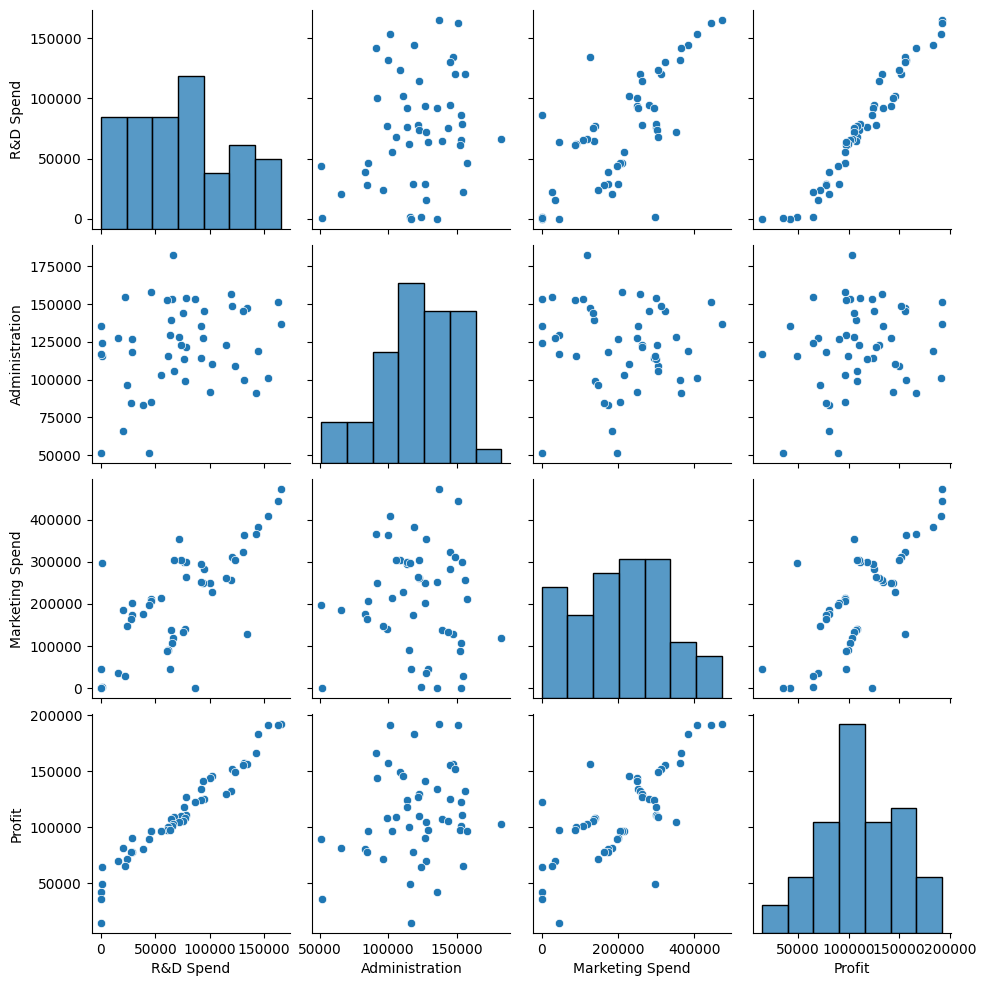

In [10]:
sns.pairplot(data)

In [11]:
data.info() # ko có giá trị null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


#### Trích xuất đặc trưng

In [12]:
X = data.iloc[:,:3].values
y = data.iloc[:,4:5].values
print(X.shape, y.shape)

(50, 3) (50, 1)


In [13]:
print(X.shape, y.shape)

(50, 3) (50, 1)


#### Giảm chiều dữ liệu (PCA)

In [14]:
pca = PCA(n_components=1)   # Khởi tạo PCA với 1 thành phần chính
pca.fit(X)  # Fit PCA với dữ liệu
X_pca = pca.transform(X)    # Chuyển đổi dữ liệu sang thành phần chính đầu tiên
print(X_pca.shape, y.shape)

(50, 1) (50, 1)


In [15]:
X_pca.T

array([[ 275938.82938581,  248371.41318817,  211342.97323503,
         185039.27529634,  168084.83912996,  162050.1719024 ,
         -63097.19227455,  124109.72127534,  109611.4455505 ,
         104069.26015231,   25279.96136451,   44728.02492022,
          42879.57003724,   45062.2396167 ,   56512.31663047,
          60101.39859905,   52407.7249209 ,   74519.23906144,
          85605.71528212, -199189.84613364,   84889.65111307,
          86464.63694506,   88720.40245824,   88335.08630106,
         -66713.3031837 ,  -72718.56128809,  -73513.68133264,
         136082.43247978,  -91417.66822986, -102079.44970905,
        -118412.3156372 , -121495.40152681, -161301.12590955,
          -1584.01608271,   -7861.99278096,  -12957.17530624,
         -22056.67095831,  -21608.82976049,  -39562.79941793,
         -44342.03578709,  -49232.17404402,  -57425.55913096,
         -74442.15229505, -184767.37787089, -189859.31876801,
        -221102.1472603 ,   62538.32204346, -223223.35149241,
        

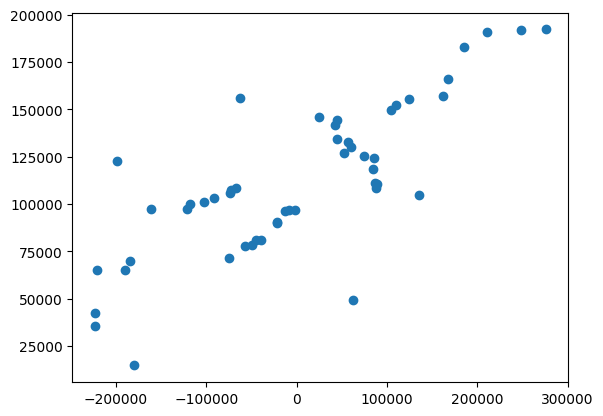

In [16]:
plt.plot(X_pca, y, 'o')

### Normalize dữ liệu

In [17]:
X = normalized(X)
X_pca = normalized(X_pca)
y = normalized(y)

### Chia dữ liệu thành train và test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=23)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40, 3) (10, 3) (40, 1) (10, 1)


### Least Square

In [19]:
class LinearRegression:
    def __init__(self, X, y, name):
        self.X = X
        self.y = y
        self.name = name
        self.mean_X = sum(X) / len(X)
        self.mean_y = sum(y) / len(y)
        self.covariance = 0
        self.variance_X = 0
        self.slope = 0
        self.intercept = 0
        self.predicted_y = []
    
    def fit(self):
        for i in range(len(self.X)):
            self.covariance += (self.X[i] - self.mean_X) * (self.y[i] - self.mean_y)
            self.variance_X += (self.X[i] - self.mean_X) ** 2
        
        self.slope = self.covariance / self.variance_X
        self.intercept = self.mean_y - self.slope * self.mean_X
        
        self.predicted_y = [self.slope * x + self.intercept for x in self.X]
    
    def plot_regression(self):
        plt.scatter(self.X, self.y, label='real_data')
        plt.plot(self.X, self.predicted_y, label='y_pred', color='red')
        plt.xlabel('Profit')
        plt.ylabel(self.name)
        plt.legend()
        plt.show()

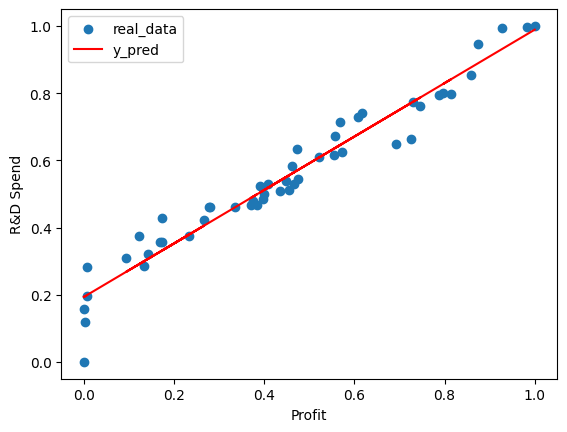

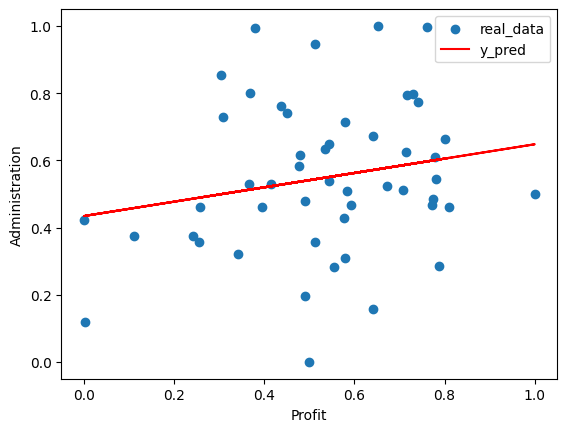

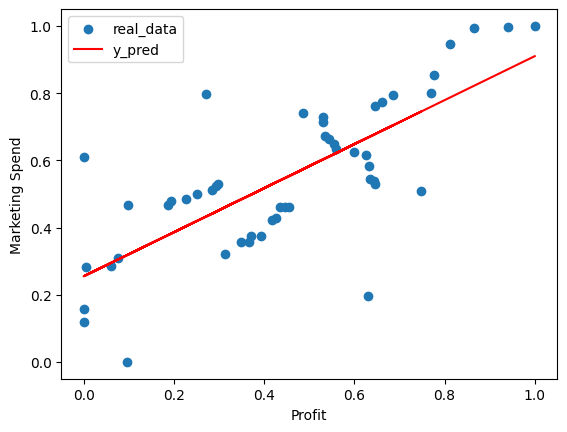

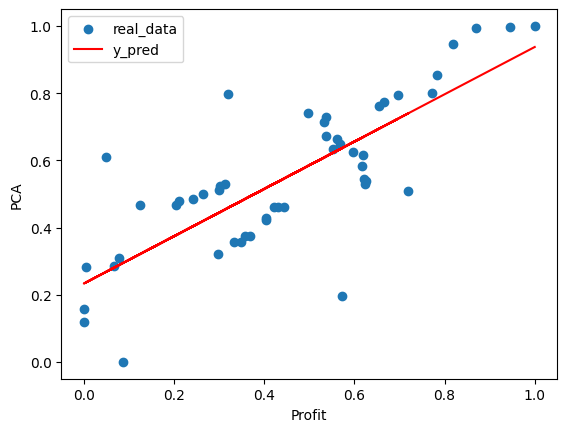

In [20]:
ln = LinearRegression(X[:, 0], y, 'R&D Spend')
ln.fit()
ln.plot_regression()
ln = LinearRegression(X[:, 1], y, 'Administration')
ln.fit()
ln.plot_regression()
ln = LinearRegression(X[:, 2], y, 'Marketing Spend')
ln.fit()
ln.plot_regression()
ln = LinearRegression(X_pca, y, 'PCA')
ln.fit()
ln.plot_regression()

### Ridge Regression

In [21]:
# Ridge Regression
class RidgeRegression:
    def __init__(self, learning_rate, iterations, l2_penalty, loss=False):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l2_penalty = l2_penalty
        self.loss = loss
        
    def fit(self, X, y):
        self.m, self.n = X.shape
        self.W = np.zeros([1, self.n])
        self.b = np.zeros([1, 1])
        self.X = X
        self.y = y

        for _ in range(self.iterations):
            self.update_weights()
            loss = self.loss_function(self.X, self.y)
            if self.loss:
                print(f"Loss: {loss}")
    
    def l2_penalty_term(self):
        return self.l2_penalty * np.sum(self.W**2)
    
    def update_weights(self):
        y_pred = self.predict(self.X)
        dW = -(2 * (self.X.T).dot(self.y - y_pred)) / self.m + (2 * self.l2_penalty_term() * self.W).T # cập nhập l2 penalty
        db = - 2 * np.sum(self.y - y_pred) / self.m # thành phần l2 penalty không có ảnh hưởng đến bias
        self.W = self.W - self.learning_rate * dW.T
        self.b = self.b - self.learning_rate * db

    def score(self, X, y):
        y_pred = self.predict(X)
        ssr = np.sum((y - y_pred)**2)
        sst = np.sum((y - np.mean(y))**2)
        r2_score = 1 - (ssr / sst)
        return r2_score
            
    def predict(self, X):
        return X.dot(self.W.T) + self.b
    
    def loss_function(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred)**2)
        return mse + self.l2_penalty_term()

In [22]:
reg = RidgeRegression(0.003, 1000, 0.03, loss=True)
reg.fit(X_train, y_train)

Loss: 0.34536281449547895
Loss: 0.33895094119258357
Loss: 0.33266794787699006
Loss: 0.3265112408329786
Loss: 0.3204782785308966
Loss: 0.3145665705756695
Loss: 0.3087736766766005
Loss: 0.30309720563802406
Loss: 0.2975348143703858
Loss: 0.29208420692132975
Loss: 0.28674313352638564
Loss: 0.2815093896788542
Loss: 0.27638081521849794
Loss: 0.27135529343865467
Loss: 0.2664307502113959
Loss: 0.261605153130364
Loss: 0.2568765106709248
Loss: 0.2522428713672859
Loss: 0.2477023230062312
Loss: 0.24325299183713728
Loss: 0.23889304179793608
Loss: 0.2346206737567026
Loss: 0.2304341247685474
Loss: 0.2263316673475036
Loss: 0.2223116087531039
Loss: 0.21837229029134828
Loss: 0.21451208662977014
Loss: 0.2107294051263148
Loss: 0.20702268517175018
Loss: 0.20339039754533422
Loss: 0.19983104378347047
Loss: 0.19634315556108897
Loss: 0.1929252940854932
Loss: 0.18957604950242132
Loss: 0.1862940403140739
Loss: 0.1830779128088658
Loss: 0.17992634050266418
Loss: 0.17683802359128095
Loss: 0.17381168841399133
Loss: 

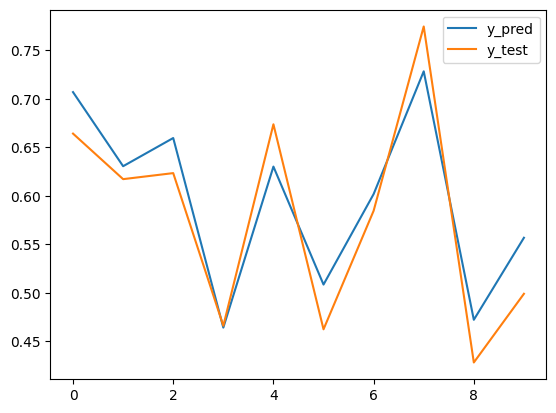

In [23]:
# plot y_pred and y_test
y_pred = reg.predict(X_test)
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend()

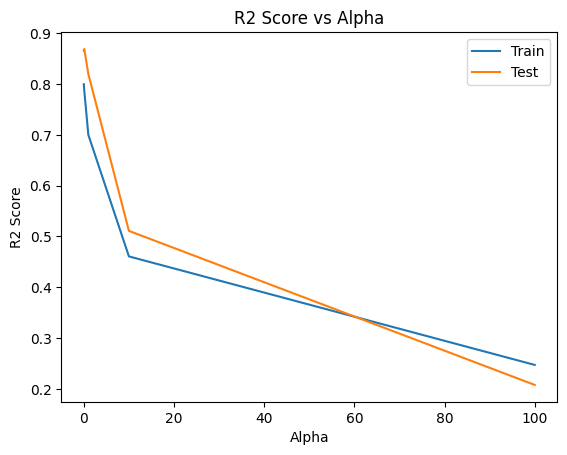

In [24]:
plot_graph_with_varying_alpha(X_train, y_train, X_test, y_test, alpha_values, beta_values, 'ridge')

#### Handle với dữ liệu đã giảm chiều

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=23)

In [26]:
reg = RidgeRegression(0.003, 10000, 0.0003)
reg.fit(X_pca_train, y_pca_train)

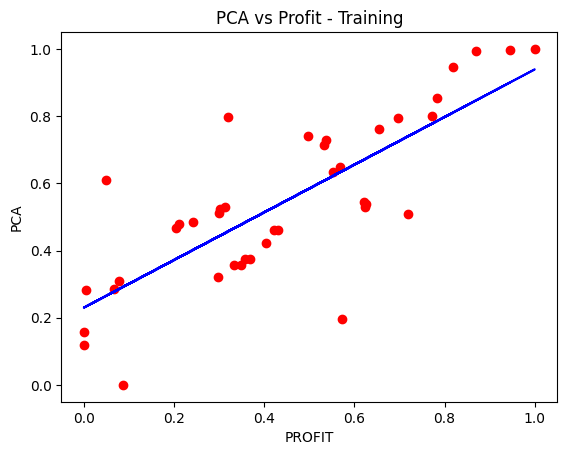

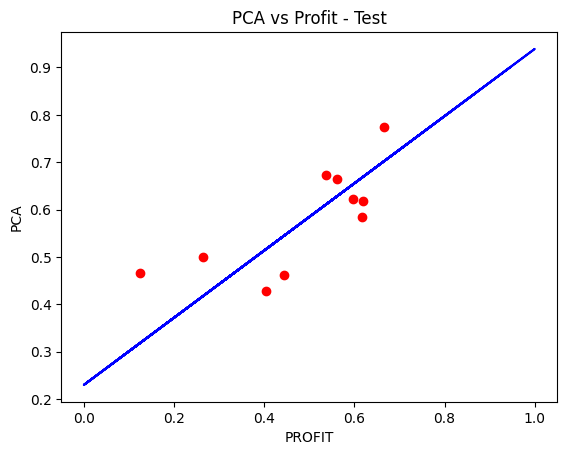

In [27]:
plot_train(X_pca_train, y_pca_train, reg)
plot_test(X_pca_train, X_pca_test, y_pca_test, reg)

In [28]:
score=r2_score(y_pca_test,y_pred)
print("r2 score is",round(score, 4))
print("mean_sqrd_error is==",round(mean_squared_error(y_pca_test,y_pred),4))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_pca_test,y_pred)))

r2 score is 0.8673
mean_sqrd_error is== 0.0015
root_mean_squared error of is== 0.038798497356276496


In [29]:
table = get_feature_importance(table, 'Ridge Regression', reg, X_pca_test, y_pca_test)

### LASSO Regression

In [30]:
# Lasso Regression
class LassoRegression:
    def __init__(self, learning_rate, iterations, l1_penalty, loss=False):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l1_penalty = l1_penalty
        self.loss = loss
        
    def fit(self, X, y):
        self.m, self.n = X.shape
        self.W = np.zeros([1, self.n])
        self.b = np.zeros([1, 1])
        self.X = X
        self.y = y

        for _ in range(self.iterations):
            self.update_weights()
            loss = self.loss_function(self.X, self.y)
            if self.loss:
                print(f"Loss: {loss}")
    
    def l1_penalty_term(self):
        return self.l1_penalty * np.sum(np.abs(self.W))
    
    def update_weights(self):
        y_pred = self.predict(self.X)
        dW = -(2 * (self.X.T).dot(self.y - y_pred)) / self.m + (2 * self.l1_penalty_term() * self.W).T # cập nhập l1 penalty
        db = - 2 * np.sum(self.y - y_pred) / self.m # thành phần l1 penalty không có ảnh hưởng đến bias
        self.W = self.W - self.learning_rate * dW.T
        self.b = self.b - self.learning_rate * db
    
    def score(self, X, y):
        y_pred = self.predict(X)
        ssr = np.sum((y - y_pred)**2)
        sst = np.sum((y - np.mean(y))**2)
        r2_score = 1 - (ssr / sst)
        return r2_score
    
    def predict(self, X):
        return X.dot(self.W.T) + self.b
    
    def loss_function(self, X, y):
        y_pred = self.predict(X) 
        mse = np.mean((y - y_pred)**2)
        return mse + self.l1_penalty_term()

In [31]:
las = LassoRegression(0.003, 1000, 0.001, loss=True) 
las.fit(X_train, y_train)

Loss: 0.3474192604934604
Loss: 0.3429967393108788
Loss: 0.3386377235502404
Loss: 0.33434129890545305
Loss: 0.3301065642347387
Loss: 0.325932631371105
Loss: 0.3218186249355442
Loss: 0.31776368215292344
Loss: 0.31376695267052296
Loss: 0.3098275983791883
Loss: 0.3059447932370567
Loss: 0.30211772309582136
Loss: 0.29834558552949575
Loss: 0.2946275896656445
Loss: 0.2909629560190433
Loss: 0.28735091632773285
Loss: 0.2837907133914338
Loss: 0.28028160091228765
Loss: 0.27682284333789015
Loss: 0.2734137157065847
Loss: 0.27005350349498264
Loss: 0.26674150246767925
Loss: 0.26347701852913213
Loss: 0.26025936757767365
Loss: 0.25708787536162325
Loss: 0.2539618773374726
Loss: 0.2508807185301118
Loss: 0.24784375339506773
Loss: 0.24485034568272585
Loss: 0.24189986830450666
Loss: 0.23899170320096874
Loss: 0.23612524121181078
Loss: 0.23329988194774479
Loss: 0.23051503366421422
Loss: 0.22777011313692982
Loss: 0.22506454553919772
Loss: 0.22239776432101305
Loss: 0.2197692110898947
Loss: 0.2171783354934355
Los

In [32]:
las.score(X_test,y_test)

0.5200212334920382

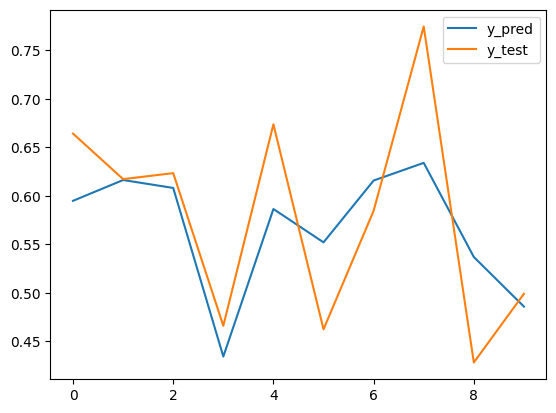

In [33]:
# plot y_pred and y_test
y_pred = las.predict(X_test)
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend()

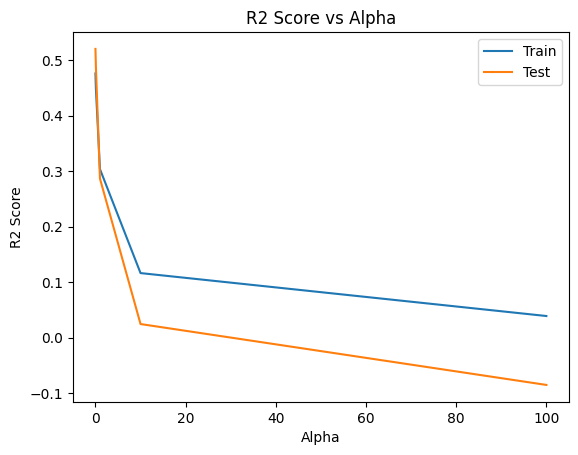

In [34]:
plot_graph_with_varying_alpha(X_train, y_train, X_test, y_test, alpha_values, beta_values, 'lasso')

#### Handle với dữ liệu đã giảm chiều

In [35]:
las = LassoRegression(0.004, 100000, 0.75)
las.fit(X_pca_train, y_pca_train)

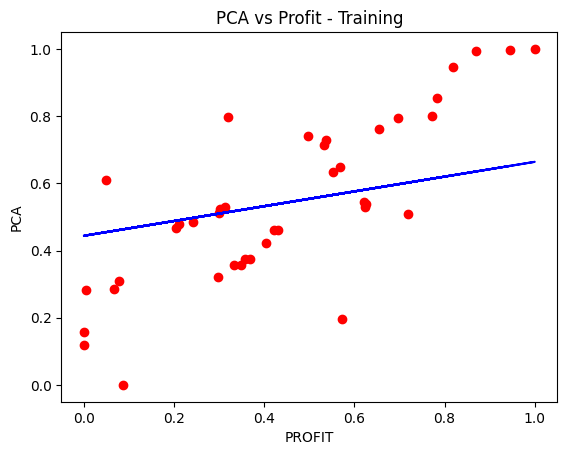

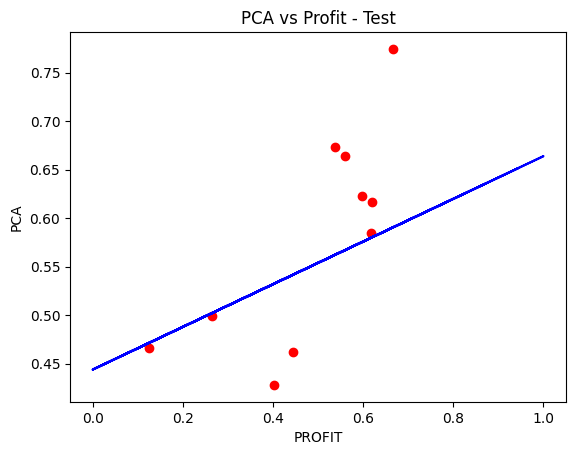

In [36]:
plot_train(X_pca_train, y_pca_train, las)
plot_test(X_pca_train, X_pca_test, y_pca_test, las)

In [37]:
score=r2_score(y_pca_test,y_pred)
print("r2 score is",round(score, 4))
print("mean_sqrd_error is==",round(mean_squared_error(y_pca_test,y_pred),4))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_pca_test,y_pred)))

r2 score is 0.52
mean_sqrd_error is== 0.0054
root_mean_squared error of is== 0.07377947836963386


In [38]:
table = get_feature_importance(table, 'Lasso Regression', las, X_pca_test, y_pca_test) 

### ElasticNet Regression

In [39]:
class ElasticNetRegression:
    def __init__(self, learning_rate, iterations, l1_ratio, l2_penalty, loss=False):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l1_ratio = l1_ratio
        self.l2_penalty = l2_penalty
        self.loss = loss
        
    def fit(self, X, y):
        self.m, self.n = X.shape
        self.W = np.zeros([1, self.n])
        self.b = np.zeros([1, 1])
        self.X = X
        self.y = y

        for _ in range(self.iterations):
            self.update_weights()
            loss = self.loss_function(self.X, self.y)
            if self.loss:
                print(loss)
    
    def l1_penalty_term(self):
        return self.l1_ratio * self.l2_penalty * np.sum(np.abs(self.W))
    
    def l2_penalty_term(self):
        return (1 - self.l1_ratio) * self.l2_penalty * np.sum(self.W**2)
    
    def update_weights(self):
        y_pred = self.predict(self.X)
        dW = -(2 * (self.X.T).dot(self.y - y_pred)) / self.m + (self.l1_penalty_term() + self.l2_penalty_term()) * self.W.T # cập nhập l1 và l2 penalty
        db = - 2 * np.sum(self.y - y_pred) / self.m # thành phần l1 và l2 penalty không có ảnh hưởng đến bias
        self.W = self.W - self.learning_rate * dW.T
        self.b = self.b - self.learning_rate * db

    def score(self, X, y):
        y_pred = self.predict(X)
        ssr = np.sum((y - y_pred)**2)
        sst = np.sum((y - np.mean(y))**2)
        r2_score = 1 - (ssr / sst)
        return r2_score
            
    def predict(self, X):
        return X.dot(self.W.T) + self.b
    
    def loss_function(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred)**2)
        return mse + self.l1_penalty_term() + self.l2_penalty_term()


In [40]:
ELN = ElasticNetRegression(0.003, 1000, 0.001, 0.02, loss=True) 
ELN.fit(X_train, y_train)

0.34741762169466633
0.3429935912704939
0.33863319341753967
0.33433551146141743
0.3300996419310139
0.3259246943682988
0.321809791140876
0.31775406725723593
0.313756670184672
0.3098167596698197
0.3059335075617825
0.30210609763780816
0.29833372543147535
0.2946155980633574
0.29095093407412603
0.28733896326006053
0.2837789265109267
0.28027007565019235
0.2768116732775452
0.27340299261368
0.27004331734732223
0.26673194148445584
0.2634681691997236
0.2602513146899688
0.25708070202988653
0.25395566502975514
0.250875547095218
0.24783970108908412
0.2448474891951217
0.24189828278381212
0.23899146228003962
0.23612641703268583
0.23330254518610452
0.23051925355344627
0.2277759574918093
0.22507208077918833
0.22240705549319606
0.21978032189153238
0.2171913282941745
0.21463953096726499
0.21212439400867195
0.20964538923519818
0.2072019960714142
0.20479370144009404
0.2024199996542274
0.20008039231058913
0.19777438818484042
0.19550150312814163
0.1932612599652543
0.19105318839411048
0.1888768248868288
0.1867

In [41]:
ELN.score(X_test,y_test)

0.5192927290477577

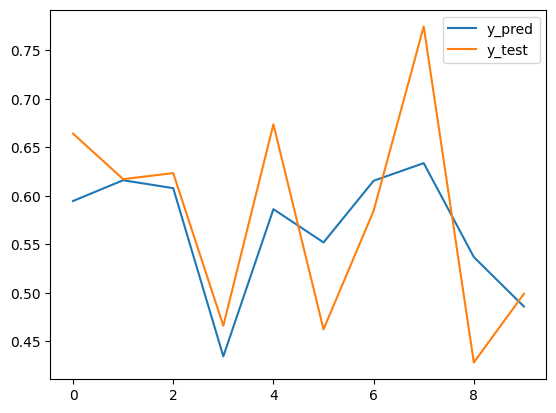

In [42]:
# plot y_pred and y_test
y_pred = ELN.predict(X_test)
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend()

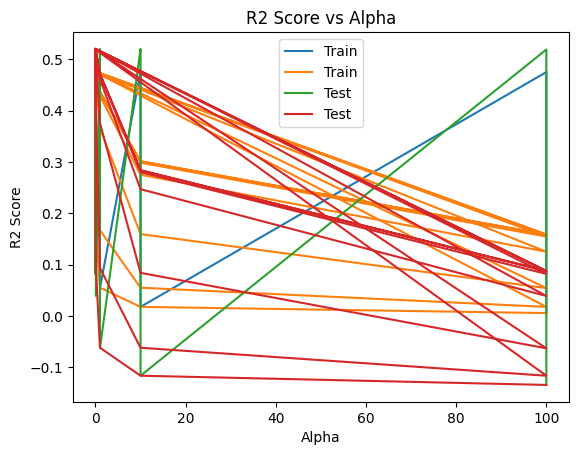

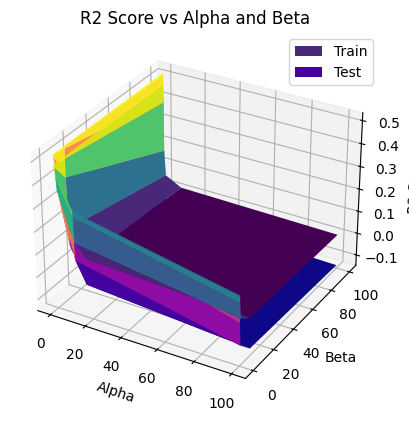

In [43]:
plot_graph_with_varying_alpha(X_train, y_train, X_test, y_test, alpha_values, beta_values, 'ELN')

#### Handle với dữ liệu đã giảm chiều

In [44]:
ELN = ElasticNetRegression(0.004, 100000, 0.75, 0.75)
ELN.fit(X_pca_train, y_pca_train)

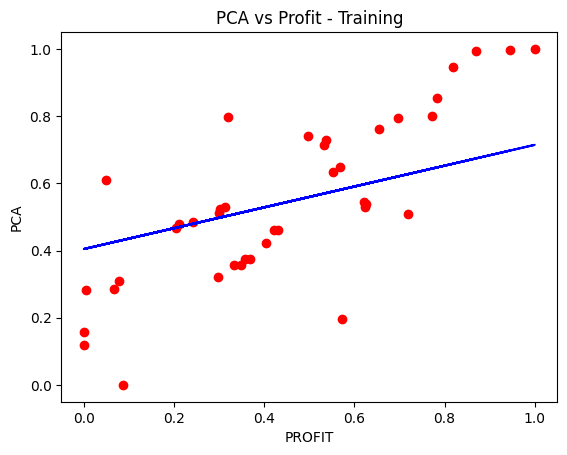

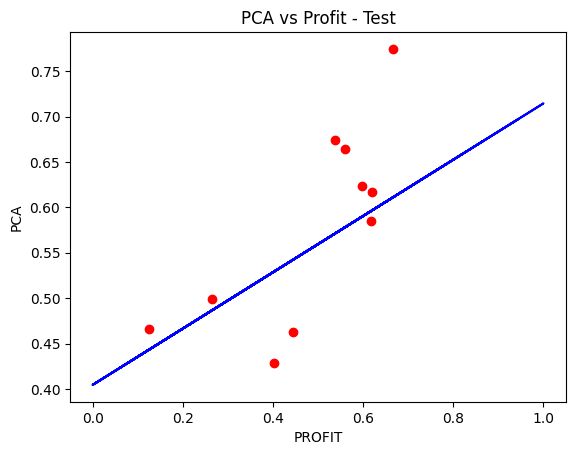

In [45]:
plot_train(X_pca_train, y_pca_train, ELN)
plot_test(X_pca_train, X_pca_test, y_pca_test, ELN)

In [46]:
score=r2_score(y_pca_test,y_pred)
print("r2 score is",round(score, 4))
print("mean_sqrd_error is==",round(mean_squared_error(y_pca_test,y_pred),4))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_pca_test,y_pred)))

r2 score is 0.5193
mean_sqrd_error is== 0.0055
root_mean_squared error of is== 0.07383544782325357


In [47]:
table = get_feature_importance(table, 'Elastic Net Regression', ELN, X_pca_test, y_pca_test)

[['Optimier', 'MSE', 'R2 Score'],
 ['Ridge Regression', 0.5637596443263742, 0.43624035567362585],
 ['Lasso Regression', 0.675051065164154, 0.32494893483584597],
 ['Elastic Net Regression', 0.5605597876599328, 0.43944021234006725]]

### Evaluate

In [55]:
table = pd.DataFrame(table)
table

,0,1,2
0,Optimier,MSE,R2 Score
1,Ridge Regression,0.56376,0.43624
2,Lasso Regression,0.675051,0.324949
3,Elastic Net Regression,0.56056,0.43944


#### Khởi tạo mô hình

In [49]:
# Create the Ridge Regression model
ridge_model = Ridge()

# Create the Lasso Regression model
lasso_model = Lasso()

# Create the ElasticNet Regression model
elasticnet_model = ElasticNet()


#### Khởi tạo chuỗi param cho GridSearch

In [50]:
# Define the parameter grid for each model
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
elasticnet_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

In [51]:
# Perform GridSearchCV for each model
ridge_grid = GridSearchCV(ridge_model, ridge_param_grid, cv=5)
lasso_grid = GridSearchCV(lasso_model, lasso_param_grid, cv=5)
elasticnet_grid = GridSearchCV(elasticnet_model, elasticnet_param_grid, cv=5)

In [52]:
# Fit the models
ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)
elasticnet_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]})

#### Trả về Alpha hoặc cả Beta tối ưu

In [53]:
# Get the best hyperparameters and scores for each model
ridge_best_params = ridge_grid.best_params_
ridge_best_score = ridge_grid.best_score_
lasso_best_params = lasso_grid.best_params_
lasso_best_score = lasso_grid.best_score_
elasticnet_best_params = elasticnet_grid.best_params_
elasticnet_best_score = elasticnet_grid.best_score_

In [54]:
# Print the results
print("Ridge Regression:")
print("Best Parameters:", ridge_best_params)
print("Best Score:", ridge_best_score)
print()
print("Lasso Regression:")
print("Best Parameters:", lasso_best_params)
print("Best Score:", lasso_best_score)
print()
print("ElasticNet Regression:")
print("Best Parameters:", elasticnet_best_params)
print("Best Score:", elasticnet_best_score)

Ridge Regression:
Best Parameters: {'alpha': 0.1}
Best Score: 0.5176925185046739

Lasso Regression:
Best Parameters: {'alpha': 0.01}
Best Score: 0.5149505455473985

ElasticNet Regression:
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best Score: 0.5226549250649263
